In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
# df['TotalCharges'].str.astype(float)

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
#label encode Churn
#binary encode the yes/no
#one hot encode the rest

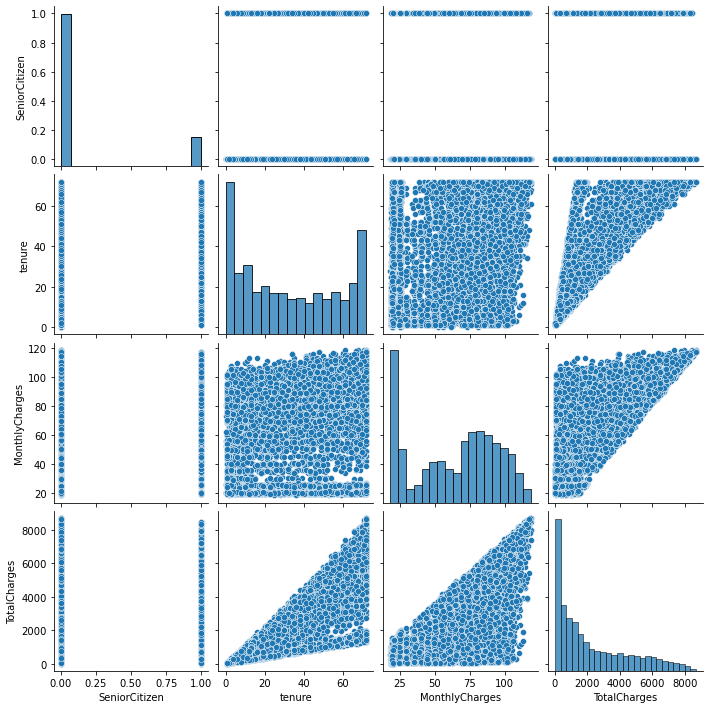

In [7]:
sns.pairplot(df)

In [8]:
df.columns = df.columns.str.lower()

In [9]:
for col in df.columns:
    print(col,df[col].nunique())

customerid 7043
gender 2
seniorcitizen 2
partner 2
dependents 2
tenure 73
phoneservice 2
multiplelines 3
internetservice 3
onlinesecurity 3
onlinebackup 3
deviceprotection 3
techsupport 3
streamingtv 3
streamingmovies 3
contract 3
paperlessbilling 2
paymentmethod 4
monthlycharges 1585
totalcharges 6530
churn 2


In [10]:
cust_id = df['customerid']
df = df.drop('customerid',axis=1)

In [11]:
ord_encode = ['gender','partner','dependents','phoneservice','multiplelines','internetservice','onlinesecurity','onlinebackup',
              'deviceprotection','techsupport','streamingtv','streamingmovies','contract','paperlessbilling','paymentmethod']
labelencode =['churn']
num = ['seniorcitizen','tenure','monthlycharges','totalcharges']

In [12]:
X = df[ord_encode].join(df[num],how='left')
y = df[labelencode]

from sklearn.model_selection import train_test_split

X_t, X_test, y_t, y_test = train_test_split(X,y,random_state=0)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_t,y_t,random_state=0)

Impute missing values as 0

In [14]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(strategy='constant',fill_value=0)
X_train_im = impute.fit_transform(X_train)
X_val_im = impute.transform(X_val)

X_train_im = pd.DataFrame(X_train_im,columns=X.columns)
X_val_im = pd.DataFrame(X_val_im,columns=X.columns)

In [15]:
from sklearn.preprocessing import OrdinalEncoder
#ord encode categoticals
ordi = OrdinalEncoder(dtype=np.int)

X_train_ord = ordi.fit_transform(X_train_im[ord_encode])
X_val_ord = ordi.transform(X_val_im[ord_encode])

X_train_ord = pd.DataFrame(X_train_ord,columns=X[ord_encode].columns)
X_val_ord = pd.DataFrame(X_val_ord,columns=X[ord_encode].columns)

from sklearn.preprocessing import StandardScaler
#scale numerical
#use median for limit effect of outliers
ss = StandardScaler()

X_train_num = ss.fit_transform(X_train_im[num])
X_val_num = ss.transform(X_val_im[num])

X_train_num = pd.DataFrame(X_train_num,columns=X[num].columns)
X_val_num = pd.DataFrame(X_val_num,columns=X[num].columns)

In [17]:
X_train_num

,seniorcitizen,tenure,monthlycharges,totalcharges
0,-0.427069,-0.017944,-0.107867,-0.183246
1,-0.427069,-0.875263,1.056297,-0.468087
2,-0.427069,1.165973,-1.501185,-0.428393
3,-0.427069,-1.038562,0.174811,-0.781296
4,-0.427069,0.676076,-1.511220,-0.601398
...,...,...,...,...
3956,-0.427069,0.716901,-0.663187,-0.020924
3957,-0.427069,1.574220,1.504567,2.471672
3958,-0.427069,0.104530,0.713404,0.368814
3959,-0.427069,-0.630315,0.332040,-0.470857


In [20]:
#combine the categorical and numerical dfs

X_train_sc = X_train_ord.join(X_train_num,how='left')
X_val_sc = X_val_ord.join(X_val_num,how='left')

In [29]:
#encode the labels

from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()

y_train = lbl.fit_transform(np.array(y_train))
y_val = lbl.transform(y_val)

y_train_enc = pd.DataFrame(y_train,columns=y.columns)
y_val_enc = pd.DataFrame(y_val,columns=y.columns)

In [33]:
y_val_enc

,churn
0,0
1,0
2,0
3,0
4,0
...,...
1316,0
1317,0
1318,0
1319,0
